# Forecasting using spatio-temporal data with combined Graph Convolution + LSTM model

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

The dynamics of many real-world phenomena are spatio-temporal in nature. Traffic forecasting is a quintessential example of spatio-temporal problems for which we present here a deep learning framework that models speed prediction using spatio-temporal data. The task is challenging due to two main inter-linked factors: (1) the complex spatial dependency on road networks, and (2) non-linear temporal dynamics with changing road conditions.

To address these challenges, here we  explore a neural network architecture that learns from both the spatial road network data and time-series of historical speed changes to forecast speeds on road segments at a future time. In the following we demo how to forecast speeds on road segments through a `graph convolution` and `LSTM` hybrid model.  The spatial dependency of the road networks are learnt through multiple graph convolution layers  stacked over multiple LSTM,  sequence to sequence model, layers that leverage the historical speeds on top of the network structure to predicts speeds in the future for each entity. 

The architecture of the gcn-lstm model is inpired by the paper: [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://ieeexplore.ieee.org/document/8809901).

The authors have made available the implementation of their model in their github [repo](https://github.com/lehaifeng/T-GCN).
There has been a few differences in the architecture proposed in the paper and the implementation of the graph convolution component, these issues have been documented [here](https://github.com/lehaifeng/T-GCN/issues/18) and [here](https://github.com/lehaifeng/T-GCN/issues/14). The `GraphConvolutionLSTM` model in `StellarGraph`  emulates the model as explained in the paper while giving additional flexibility of adding any number of `graph convolution` and `LSTM` layers. 

Concretely, the architecture of `GraphConvolutionLSTM` is as follows:

1. User defined number of  graph convolutional layers (Reference: [Kipf & Welling (ICLR 2017)](http://arxiv.org/abs/1609.02907)).
2. User defined number of  LSTM layers. The [TGCN](https://ieeexplore.ieee.org/document/8809901) uses GRU instead of LSTM. In practice there are not any remarkable differences between the two types of layers. We use LSTM as they are more frequently used.
3. A Dropout and a Dense layer as they experimentally showed improvement in performance and managing over-fitting.

## References: 

* [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://ieeexplore.ieee.org/document/8809901)
* [https://github.com/lehaifeng/T-GCN](https://github.com/lehaifeng/T-GCN)
* [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907)

**Note: this method is applicable for uni-variate timeseries forecasting.**

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

## Data

We apply the gcn-lstm model to the **Los-loop** data. This traffic dataset
contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish
et al., 2014).  There are several processed versions of this dataset used by the research community working in Traffic forecasting space. 

This demo is based on the pre-processed version of the dataset used by the TGCN paper. It can be directly accessed from there [github repo](https://github.com/lehaifeng/T-GCN/tree/master/data). 

This dataset  contains traffic speeds from Mar.1 to Mar.7, 2012 of 207 sensors, recorded every 5 minutes. 

In order to use the model, we need:

* A N by N adjacency matrix, which describes the distance relationship between the N sensors,
* A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.

A couple of other references for the same data albeit different time length are as follows: 

* [DIFFUSION CONVOLUTIONAL RECURRENT NEURAL NETWORK: DATA-DRIVEN TRAFFIC FORECASTING](https://github.com/liyaguang/DCRNN/tree/master/data): This dataset consists of 207 sensors and collect 4 months of data ranging from Mar 1st 2012 to Jun 30th 2012 for the experiment. It has some missing values.
* [ST-MetaNet: Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning](https://github.com/panzheyi/ST-MetaNet/tree/master/traffic-prediction). This work uses the DCRNN pre-proccessed data.

## Loading and pre-processing the data

In [4]:
import stellargraph as sg

This demo is based on the pre-processed version of the dataset used by the TGCN paper.

In [5]:
dataset = sg.datasets.METR_LA()

/anaconda3/envs/stellargraph/lib/python3.6/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: METR_LA is experimental: tests and documentation missing (see: https://github.com/stellargraph/stellargraph/issues/1303). It may be difficult to use and may have major changes at any time.
  """Entry point for launching an IPython kernel.


(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [6]:
speed_data, sensor_dist_adj = dataset.load()
num_nodes = speed_data.shape[1]
time_len = speed_data.shape[0]
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


**Let's look at a sample of speed data.**

In [7]:
speed_data.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,...,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,...,42.708333,69.666667,64.388889,57.972222,66.708333,57.277778,64.986111,58.902778,69.285714,58.888889


As you can see above, there are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes.  This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207  for 7 days (12X24X7).

### Forecasting with spatio-temporal data as a supervised learing problem 

Time series forecasting problem can be cast as a supervised learning problem. We can do this by using previous timesteps as input features and use the next timestep as the output to predict. Then, the spatio-temporal forecasting question can be modeled as predicting the feature value in the future, given the historical values of the feature for that entity  as well as the feature values of the entities "connected" to the entity.  For example, the speed prediction problem, the historical speeds of the sensors are the timeseries and the distance between the sensors is the indicator for connectivity or closeness of sensors.

### Train/test split

Just like for modeling any standard supervised learning problem, we first split the data into mutually exclusive train and test sets. However, unlike, a standard supervised learning problem,  in timeseries analysis, the data is in some choronological time respecting order and the train/test happens along the timeline. Lets say, we use the first `T_t` observations for training and the remaining `T - T_t` of the  total `T` observations for testing.  

In the following we use first 80% observations for training and the rest for testing.

In [8]:
def train_test_split(data, train_portion):
    time_len = data.shape[0]
    train_size = int(time_len * train_portion)
    train_data = np.array(data[:train_size])
    test_data = np.array(data[train_size:])
    return train_data, test_data

In [9]:
train_rate = 0.8

In [10]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (1612, 207)
Test data:  (404, 207)


### Scaling
It is generally a good practice to  rescale the data from the original range so that all values are within the range of 0 and 1. Normalization can be useful and even necessary when your time series data has input values with differing scales.  In the following we normalize the speed timeseries by the maximum and minimum values of speeds in the train data. 

Note: `MinMaxScaler` in `scikit learn` library is typically used for transforming data. However, in timeseries data since the features are distinct timesteps, so using the historical range of values in a particular timestep as the range of values in later timesteps, may not be correct.  Hence, we use the maximum and the minimum of the entire range of values in the timeseries to scale and transform the train and test sets respectively.

In [11]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [12]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data preparation for LSTM

We first need to prepare the data to be fed into an LSTM. 
The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

To make it concrete in terms of the speed prediction problem, we choose to use 50 minutes of historical speed observations to predict the speed in future, lets say, 1 hour ahead. Hence, we would first  reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:  

* Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict. 
* Shift the timeseries by one timestep and take the 10 observations from the current point as the input feartures and the speed one hour ahead as the output to predict. 
* Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.
* The above steps are done for each sensor. 

The function below returns the above transformed timeseries data for the model to train on. The parameter `seq_len` is the size of the past window of information. The `pre_len` is how far in the future does the model need to learn to predict. 

For this demo: 

* Each training observation are 10 historical speeds (`seq_len`).
* Each training prediction is the speed 60 minutes later (`pre_len`).

In [13]:
seq_len = 10
pre_len = 12

In [14]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(len(train_data) - int(seq_len + pre_len - 1)):
        a = train_data[
            i : i + seq_len + pre_len,
        ]
        trainX.append(a[:seq_len])
        trainY.append(a[-1])

    for i in range(len(test_data) - int(seq_len + pre_len - 1)):
        b = test_data[
            i : i + seq_len + pre_len,
        ]
        testX.append(
            b[:seq_len,]
        )
        testY.append(b[-1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [15]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 10, 207)
(1591, 207)
(383, 10, 207)
(383, 207)


## StellarGraph Graph Convolution and LSTM model

In [16]:
from stellargraph.layer import GraphConvolutionLSTM

In [17]:
gcn_lstm = GraphConvolutionLSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_size=[16,10],
    gc_activations=["relu", "relu"],
    lstm_layer_size=[200,200],
    lstm_activations=["tanh", "tanh"],
)

/anaconda3/envs/stellargraph/lib/python3.6/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GraphConvolutionLSTM is experimental: Lack of unit tests and some code refinement (see: https://github.com/stellargraph/stellargraph/issues/1131, https://github.com/stellargraph/stellargraph/issues/1132). It may be difficult to use and may have major changes at any time.
  import sys


In [18]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [19]:
model = Model(inputs=x_input, outputs=x_output)

In [20]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [21]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 207)]         0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 16, 207)           43216     
_________________________________________________________________
fixed_adjacency_graph_convol (None, 10, 207)           43216     
_________________________________________________________________
lstm (LSTM)                  (None, 10, 200)           326400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 207)               41607 

In [23]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.052001655513876116 
Test loss: 0.06169900931807006


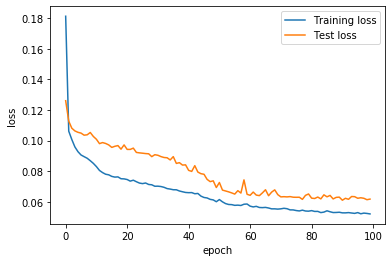

In [24]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [25]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

## Rescale values

Recale the predicted values to the original value range of the timeseries.

In [26]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [27]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Measuring the performance of the model

To understand how well the model is performing, we compare it against a naive benchmark.

1. Naive prediction: using the most recently **observed** value as the predicted value. Note, that albeit being **naive** this is a very strong baseline to beat. Especially, when speeds are recorded at a 5 minutes granularity,  one does not expect many drastic changes within such a short period of time. Hence, for short-term predictions naive is a reasonable good guess.

### Naive prediction benchmark (using latest observed value)

In [28]:
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX).transpose(1, 0, 2)[
    -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [29]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 4.318930675032405
Total (ave) MAE for naive prediction: 5.877064444860809
Total (ave) MASE for per-segment NN/naive MAE: 0.7493252099411511
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


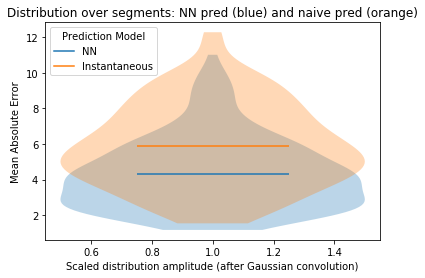

In [30]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Plot of actual and predicted speeds on a sample sensor

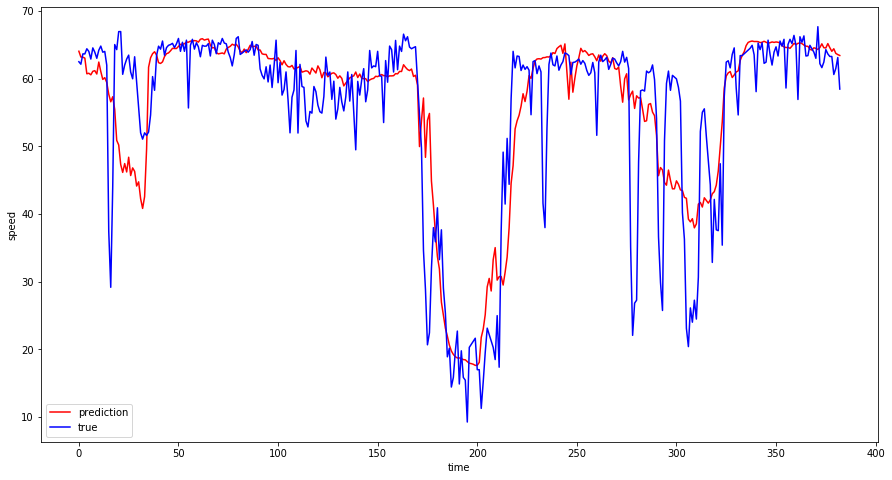

In [31]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>